# Elevated-Plus Maze Analysis

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import Core
import analysis_utils as au

from scipy import stats
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Math, Latex

InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
mouse_directory = os.path.expanduser("~") + "/Hen_Lab/Mice"

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)
    
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.startswith("Raw"):
            print("Found: {} in: {}".format(file_name, dir_name))
            raw_files.append(dir_name+"/"+file_name)

Found: Raw_EPM_drd87.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments
Found: Raw_EPM_drd46.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/drd46_experiments


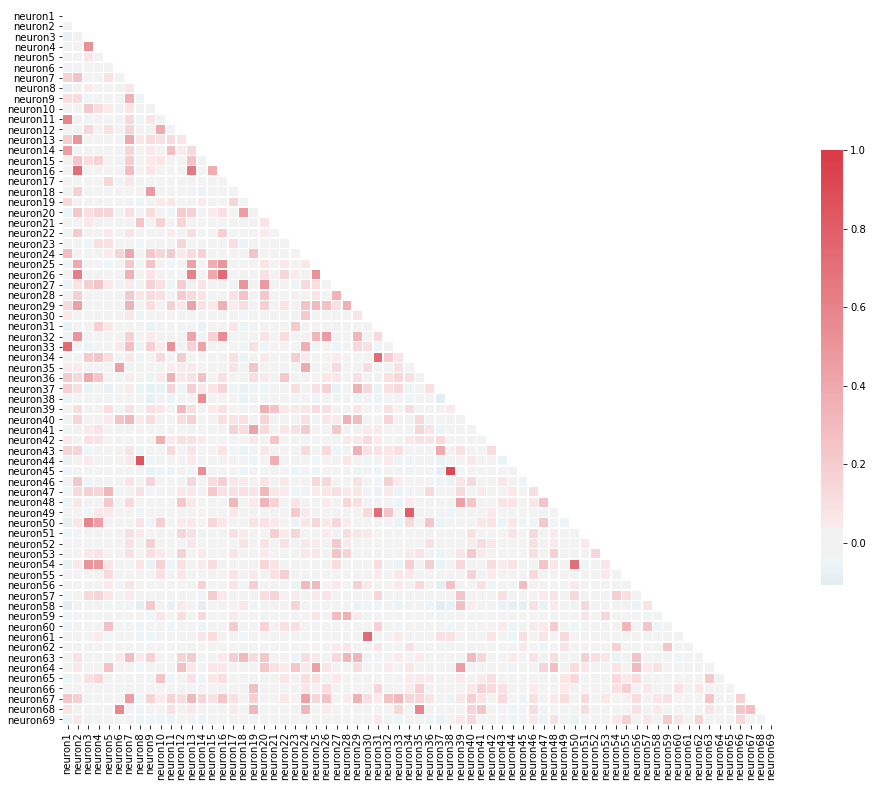

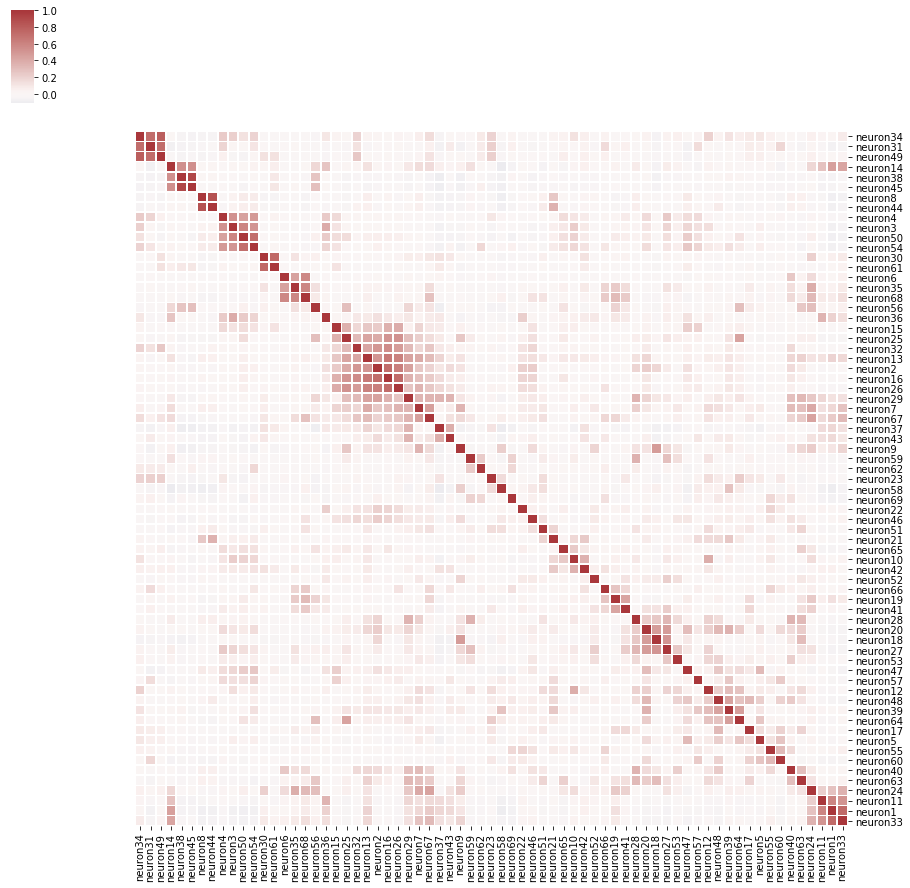

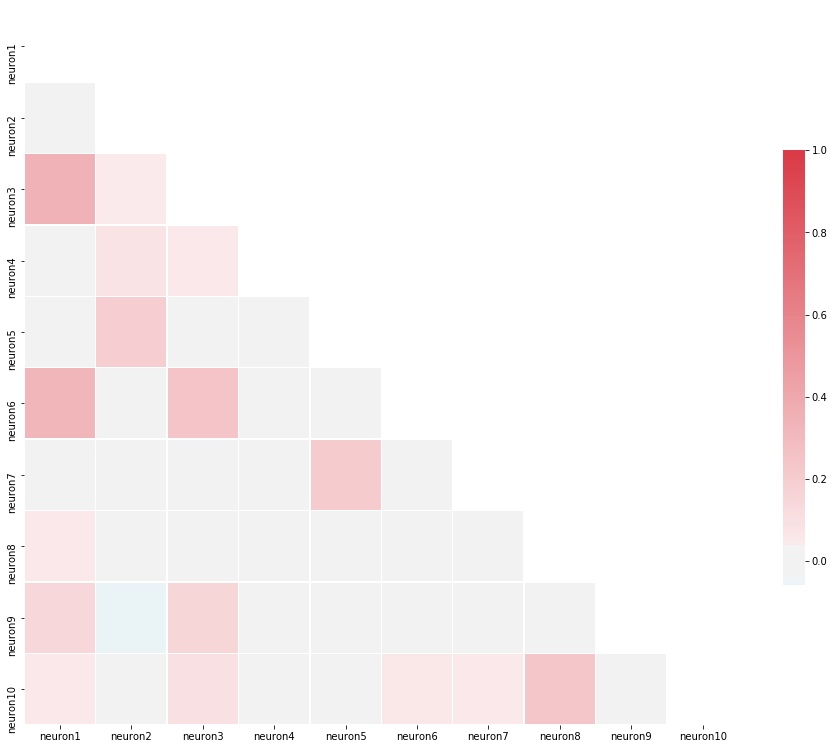

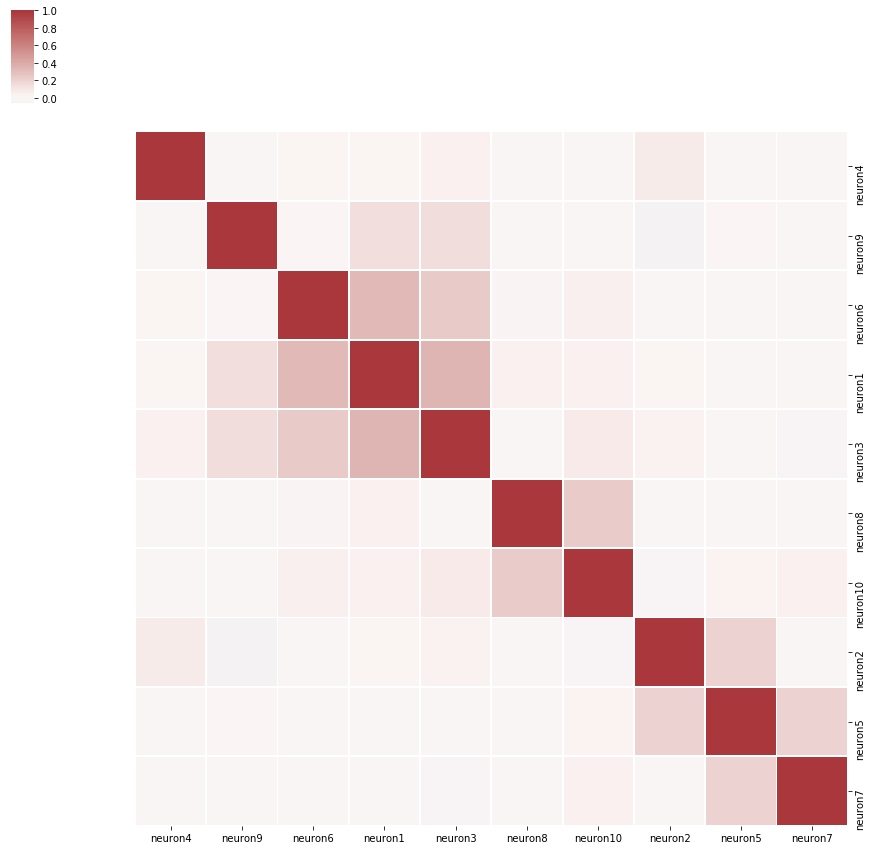

In [3]:
au.run_EPM_analysis(raw_files)

In [4]:
RAW_DRD46 = "~/Hen_Lab/Mice/drd46_experiments/Raw_EPM_drd46.csv"
RAW_DRD87 = "~/Hen_Lab/Mice/drd87_experiments/Raw_EPM_drd87.csv"
data = pd.read_csv(RAW_DRD87, header=None)

z_scored_dataframe, AUC_dataframe, cell_transients_dataframe = Core.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

z_scored_dataframe.columns = ['neuron' + str(i) for i in range(1, len(z_scored_dataframe.columns)+1)]
AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
cell_transients_dataframe.columns = ['neuron' + str(i) for i in range(1, len(cell_transients_dataframe.columns)+1)]

In [5]:
fig, r_value = au.neuron_scatter_plot_with_reg('neuron38', 'neuron45', cell_transients_dataframe)
print("Correlation(neuron38, neuron45) = {}".format(r_value))
au.neuron_line_plot('neuron38', 'neuron45', cell_transients_dataframe)

Correlation(neuron38, neuron45) = 0.9199946955038318


### We create a clustermap of all the neurons in the cell transients dataframe using the centroid method, 
$$dist(s,t)= \mid\mid c_s - c_t \mid\mid_2$$
##### where $c_s$ and $c_t$ are the centroids of clusters and $s$ and $t$, respecitvely. When two clusters $s$ and $t$ are combined into a new cluster $u$ the new centroid is computed over all the original objects in clusters $s$ and $t$. The distance then becomes the Euclidean distance between the centroid of $u$ and the centroid of a remaining cluster $v$ in the forest.

##### https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

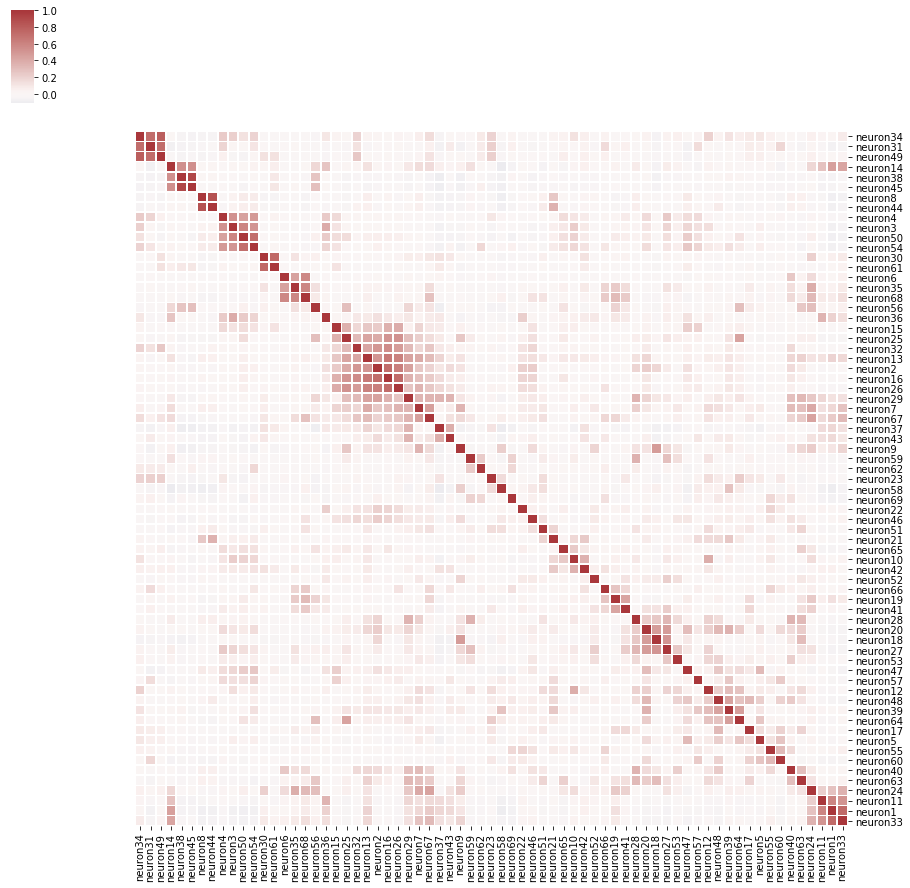

In [6]:
au.plot_clustermap(cell_transients_dataframe)

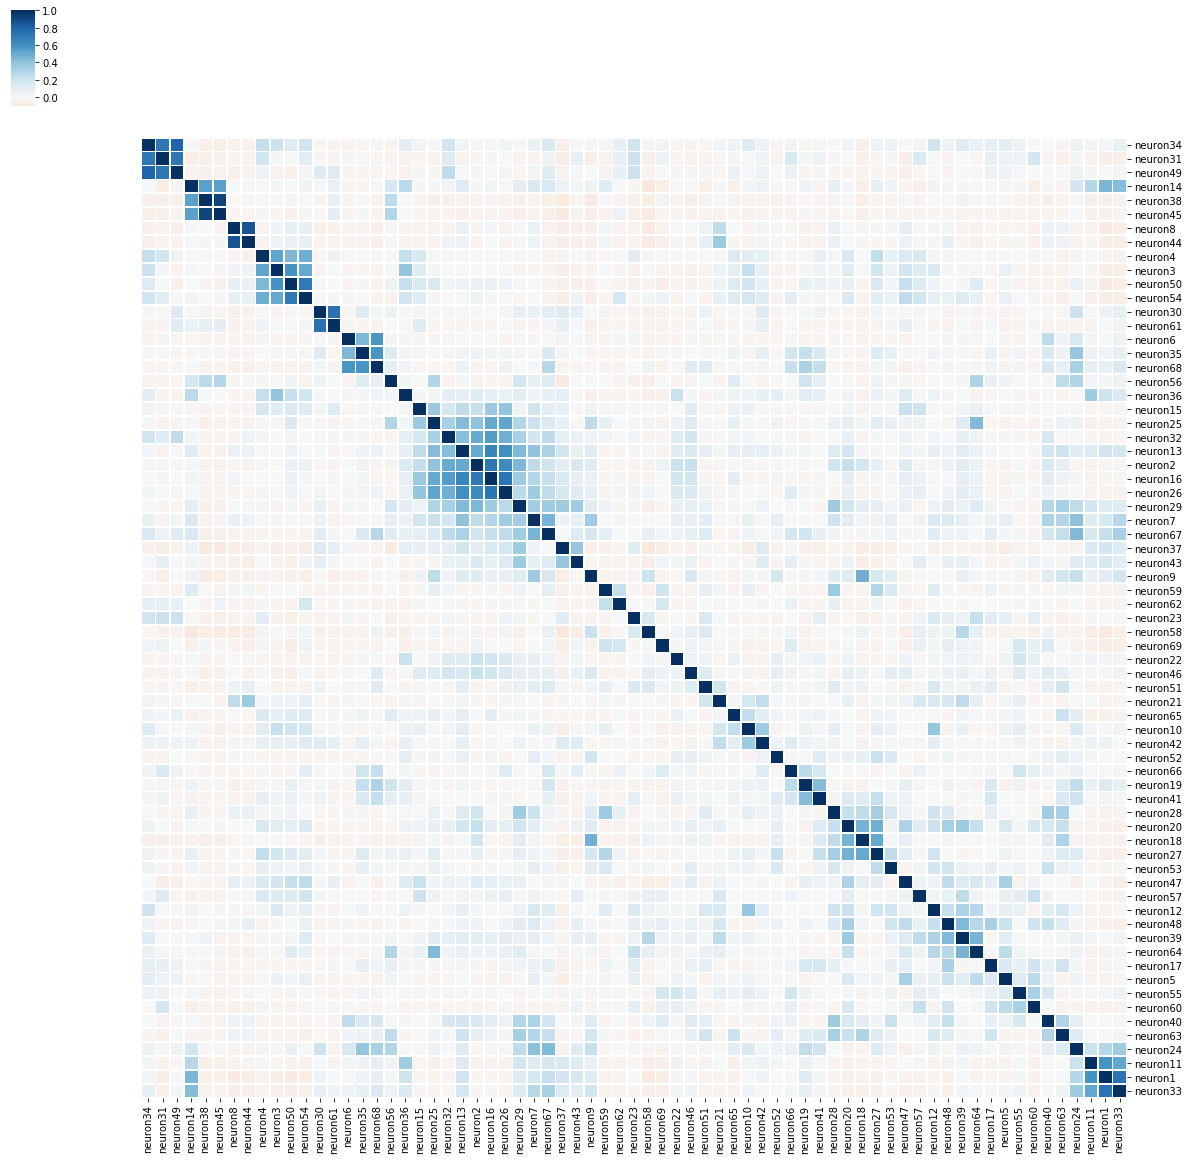

In [7]:
# TODO: Add behavior to the cluster map
import seaborn as sns
cm = sns.clustermap(cell_transients_dataframe.corr(), center=0, linewidths=.75, figsize=(20, 20), method="centroid", cmap="RdBu");
cm.ax_row_dendrogram.set_visible(False)
cm.ax_col_dendrogram.set_visible(False)

## How does the relationship between two neurons change as a function of some behavior?

In [8]:
behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

activity_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/activity_drd87.csv', header=None)
behavior_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/behavior_drd87.csv', header=None)

# Save only every nth row in order to downsample behavior Dataframes from 30fps -> 10fps
ROW_MULTIPLE = 3
behavior_df.drop(behavior_df.index[[i for i in range(0, len(behavior_df.index)) if i % ROW_MULTIPLE != 0]], inplace=True)

# For the activity Dataframe, we Change column names to corresponding neuron names 
activity_df.columns = ['neuron' + str(i) for i in range(1, len(activity_df.columns) + 1)]

# Change column names to the behavior column names found in the MossyEPM, MATLAB struct
behavior_df.columns = behavior_column_names

# Fix indexing after downsample
behavior_df.reset_index(drop=True, inplace=True)

# Make the behavior Dataframe indexed by Recording time
# behavior_df.set_index('Recording time', inplace=True)

# Make the behavior Dataframe and the activity Dataframe have the same amount of rows 
if len(behavior_df.index) > len(activity_df.index):
    diff = len(behavior_df.index) - len(activity_df.index)
    behavior_df = behavior_df[:-diff]
elif len(behavior_df.index) < len(activity_df.index):
    diff = len(activity_df.index) - len(behavior_df.index)
    activity_df = activity_df[:-diff]

# Define running frames
VELOCITY_CUTOFF = 4;

# Adds column to the end of the behavior Dataframe and make each cell in that column a 0 
# if the corresponding velocity < VELOCITY_CUTOFF or a 1 if the corresponding velocity >= VELOCITY_CUTOFF
behavior_df['Running_frames'] = [1 if velocity > VELOCITY_CUTOFF else 0 for velocity in behavior_df['Velocity'].tolist()]

# Calculate rates by arm, running, and time period

# Divide session into this many bins
TIME_BIN_FACTOR = 3; 

AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
result_dataframe = pd.concat([cell_transients_dataframe, behavior_df], axis=1)

### According to the regression model below, we predict the average flouresence level in neuron 1 and neuron 3 to be higher when drd46 was running, rather than not running

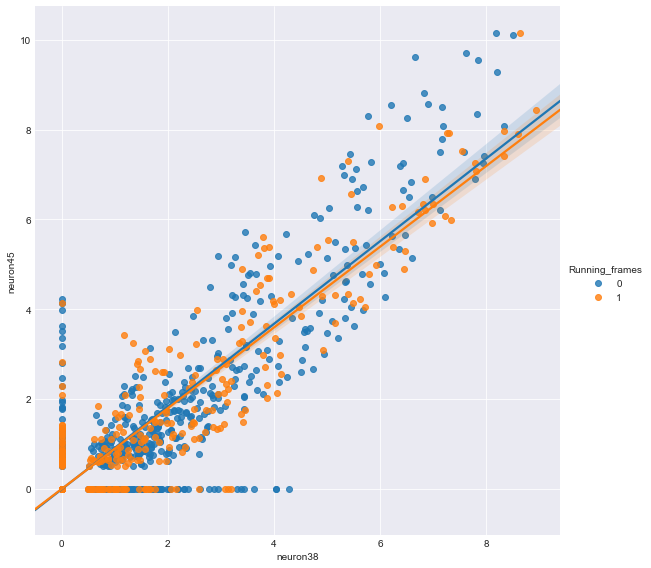

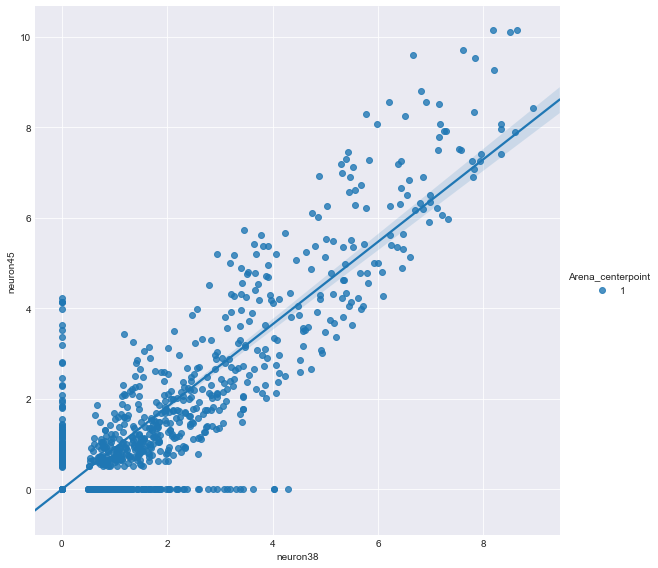

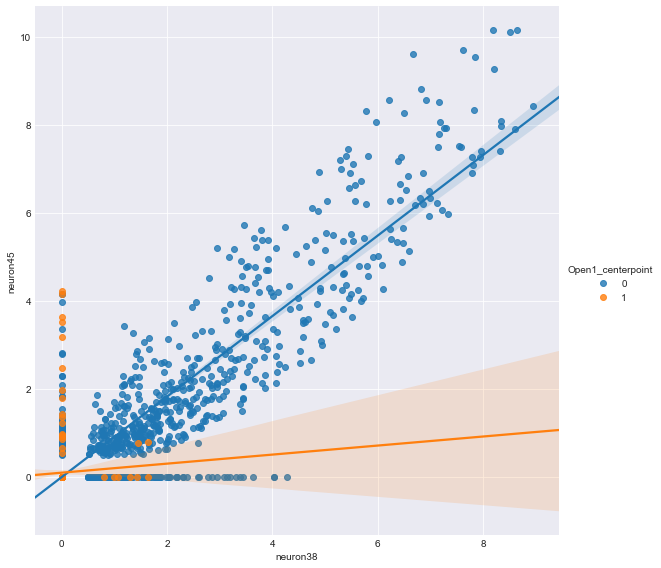

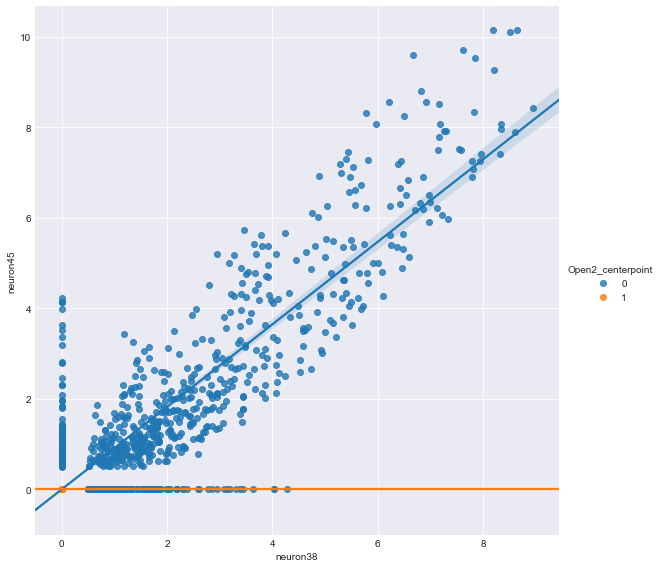

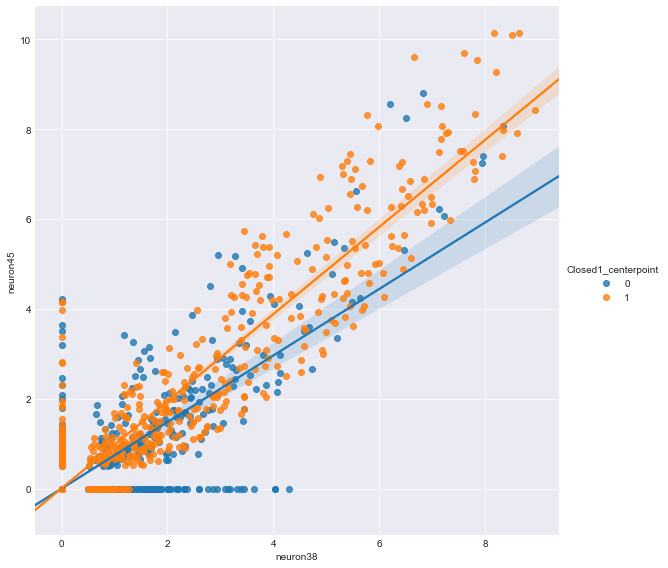

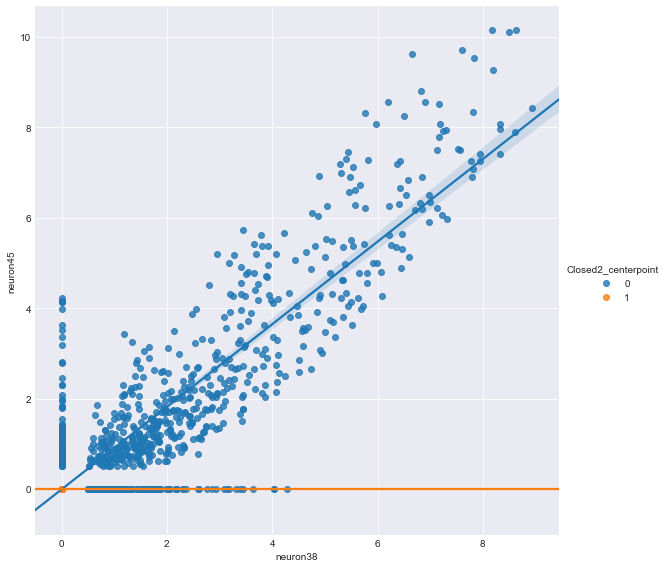

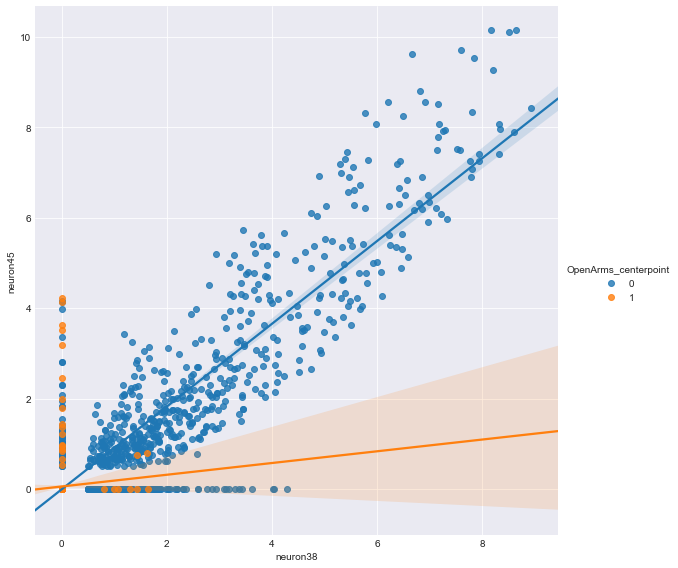

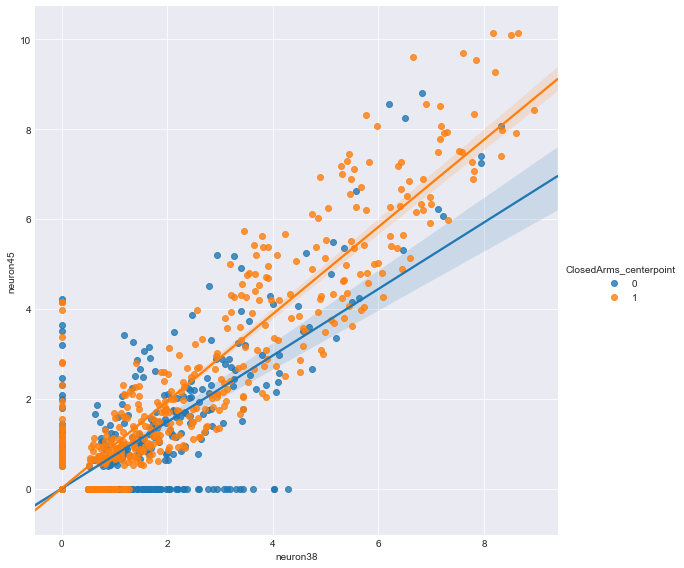

In [9]:
import seaborn as sns
sns.set_style("darkgrid")

behavior_list = ['Running_frames', 'Arena_centerpoint', 'Open1_centerpoint', 'Open2_centerpoint', 'Closed1_centerpoint', 'Closed2_centerpoint', 'OpenArms_centerpoint', 'ClosedArms_centerpoint']

for behavior in behavior_list:    
    _ = sns.lmplot(x="neuron38", y="neuron45", hue=behavior, data=result_dataframe[['neuron38', 'neuron45', 'Arena_centerpoint', 'Open1_centerpoint', 'Open2_centerpoint',
        'Closed1_centerpoint', 'Closed2_centerpoint', 'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Running_frames']], size=8);

In [10]:
# Make this function work for multiple behaviors, as discussed on 7 March 2018
def compute_d_rate(dataframe, neuron_activity_df, behavior):
    FRAME_RATE = 10
    beh_vec = dataframe.loc[dataframe[behavior] != 0, neuron_activity_df.columns]
    no_beh_vec = dataframe.loc[dataframe[behavior] == 0, neuron_activity_df.columns]
    return FRAME_RATE * (beh_vec.values.mean(axis=0) - no_beh_vec.values.mean(axis=0))

In [11]:
%timeit compute_d_rate(result_dataframe, cell_transients_dataframe, "Running_frames")

5.53 ms ± 415 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Create dataframe of real $d$ values for all neurons

In [12]:
def set_real_d_df(dataframe, neuron_activity_df, behavior):
    real_df = pd.DataFrame(columns=neuron_activity_df.columns, index=["d"])
    real_df.loc['d'] = compute_d_rate(dataframe, neuron_activity_df, behavior)
    return real_df

In [13]:
real_d_df = set_real_d_df(result_dataframe, cell_transients_dataframe, "Running_frames")
real_d_df

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
d,0.932819,1.86369,2.11705,1.72986,1.36009,0.378769,0.970921,-0.696389,2.61917,0.985573,...,0.12126,-0.410806,0.384992,1.60956,0.982585,1.22072,0.656217,1.46161,1.66994,0.786431


## Perform a cyclic shift of all indices in the result dataframe by a random integer from $[0, |resultdataframe.index|]$

In [14]:
def shuffle(n, neuron_activity_df, mouse_behavior_df, behavior):
    """ Homebrewed bootstrapping function for EPM Analysis

    Bootstrapping function that allows estimation of the sample distribution
    using cyclical shifting of the index of a pandas dataframe.

    Args:
        n: the number of random shuffles to be performed on the given data
        neuron_activity_df: the neuron activity dataframe for a given mouse
        mouse_behavior_df: the behavior dataframe for a given mouse 
        (must directly correspond with neuron_activity_df)
        behavior: the behavior to be estimated

    Returns:
        A Pandas DataFrame that contains all the neuron and behavior
        data after all the data has been bootstraped
    """ 
    shifted_beh_df = mouse_behavior_df.copy()
    shuffled_df = pd.DataFrame(columns=neuron_activity_df.columns, index=range(1, n+1))
    for row in shuffled_df.itertuples():
        shifted_beh_df.set_index(np.roll(mouse_behavior_df.index, random.randrange(1, len(mouse_behavior_df.index))), inplace=True)
        shifted_df = pd.concat([neuron_activity_df, shifted_beh_df], axis=1)
        shuffled_df.loc[row.Index] = compute_d_rate(shifted_df, neuron_activity_df, behavior)

    return shuffled_df

In [15]:
bootstrapped = shuffle(1000, cell_transients_dataframe, behavior_df, "Running_frames")

In [24]:
def confidence_plot(bootstrapped_df, real_d_df, neuron):
    sns.distplot(bootstrapped[neuron].tolist(), color='m', fit=stats.norm);
    #print("SD of {} is {},   d_value of {} is {}".format(neuron, bootstrapped[neuron].std(), neuron, real_d_df[neuron]['d']))

<Figure size 432x288 with 0 Axes>

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

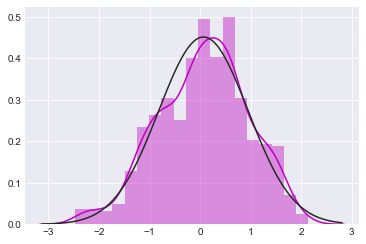

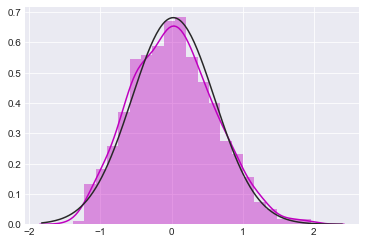

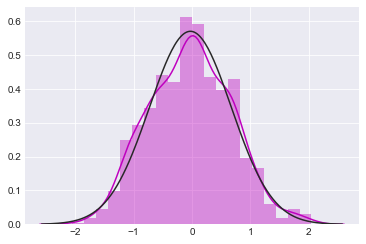

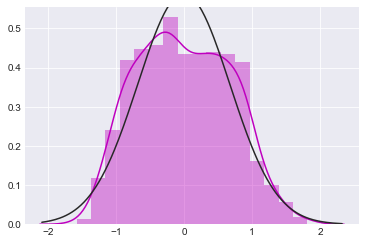

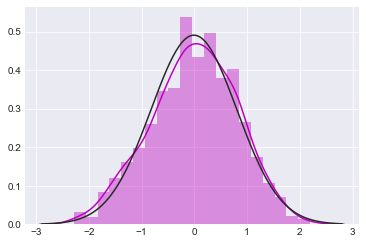

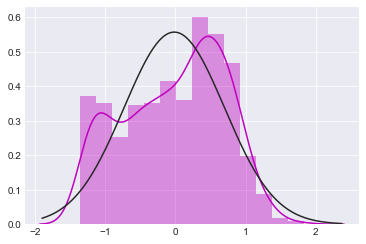

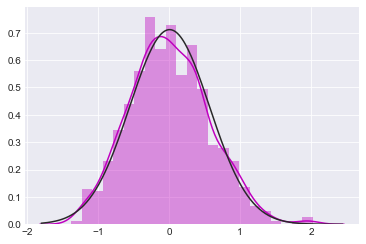

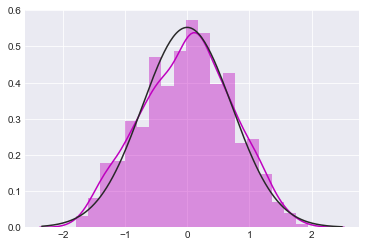

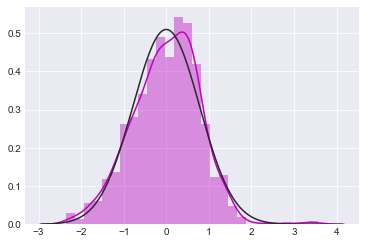

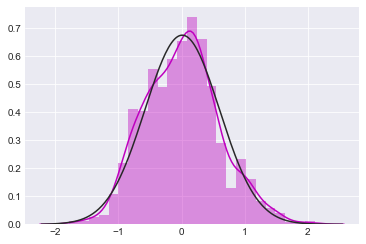

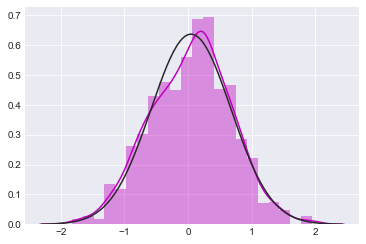

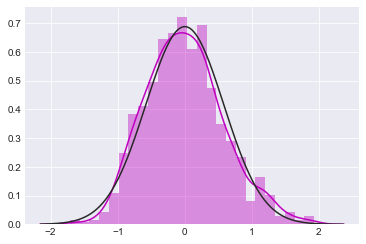

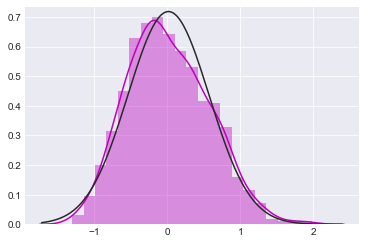

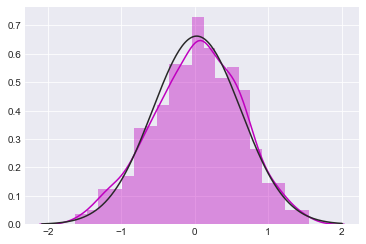

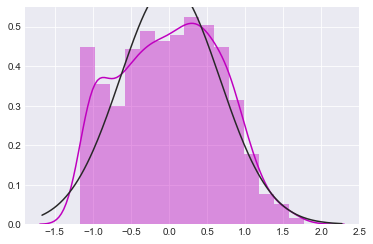

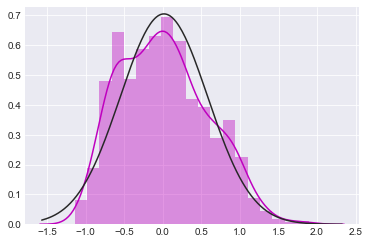

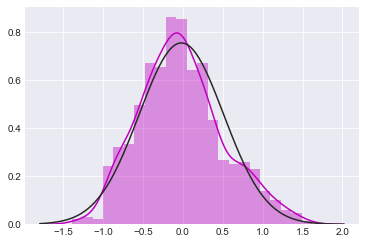

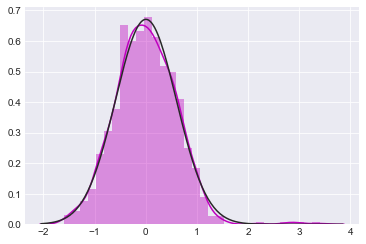

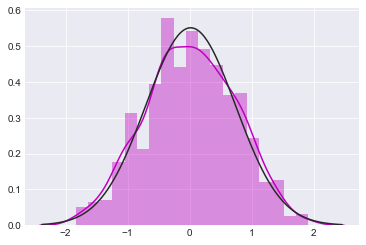

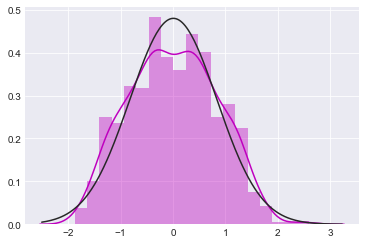

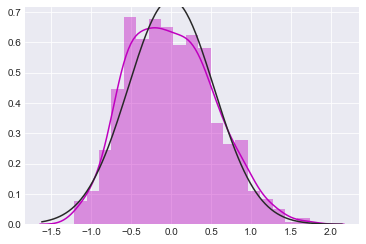

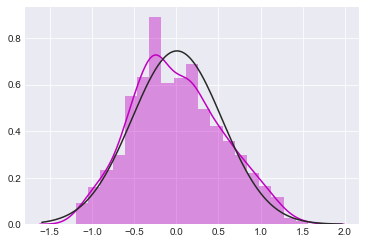

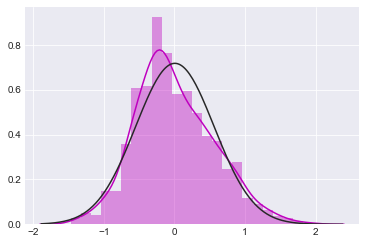

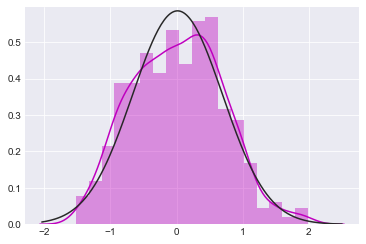

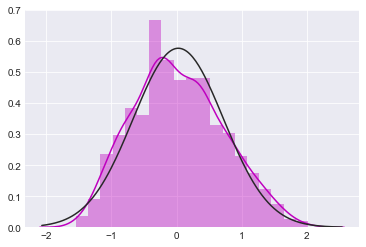

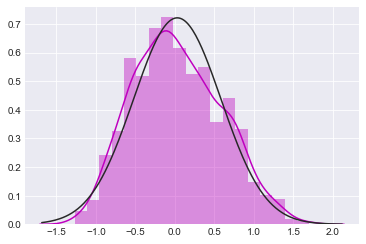

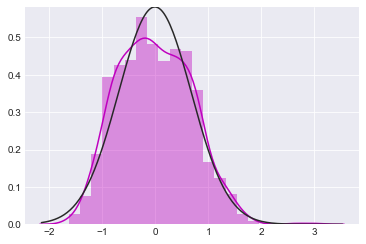

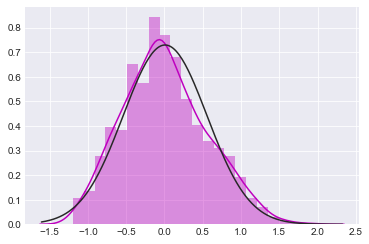

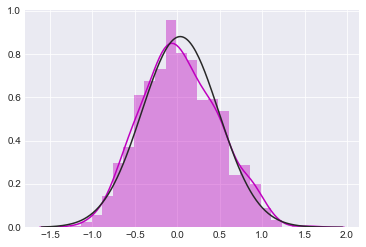

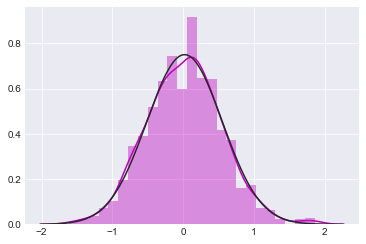

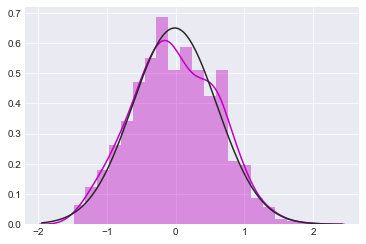

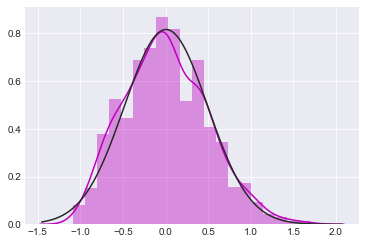

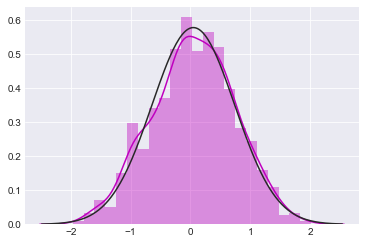

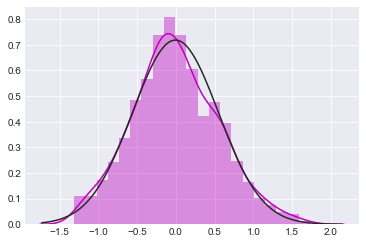

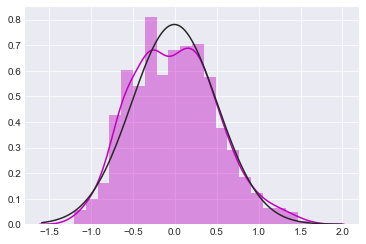

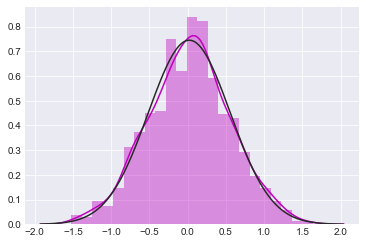

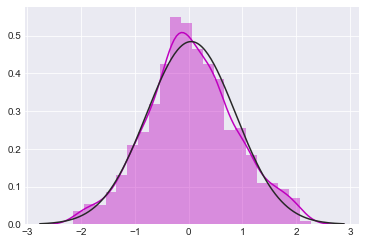

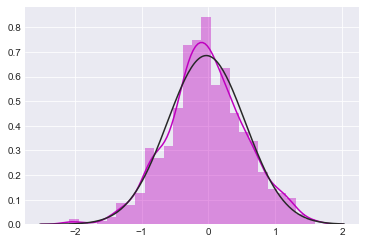

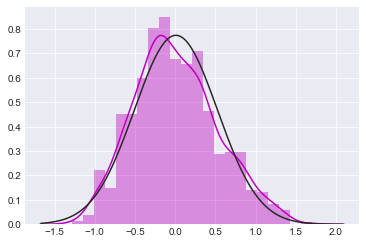

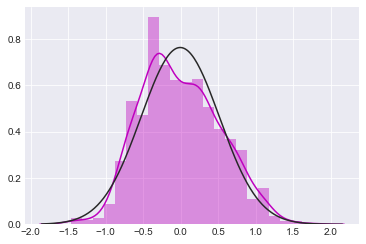

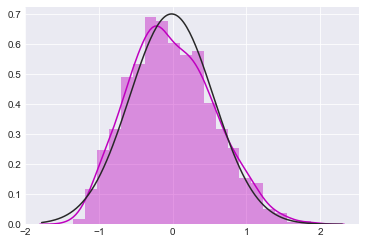

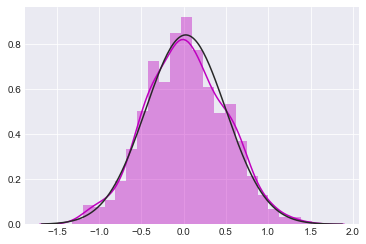

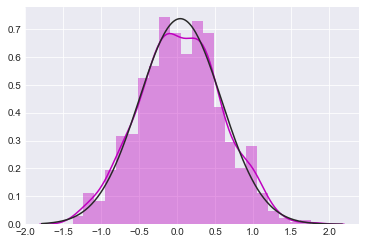

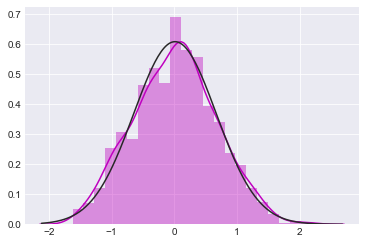

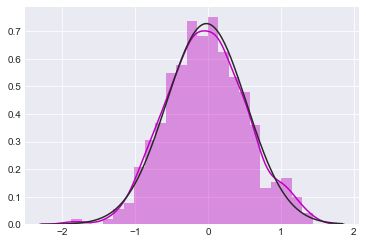

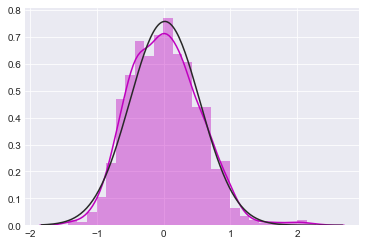

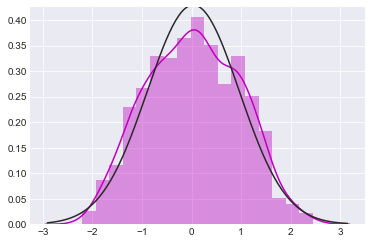

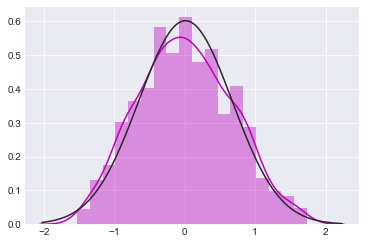

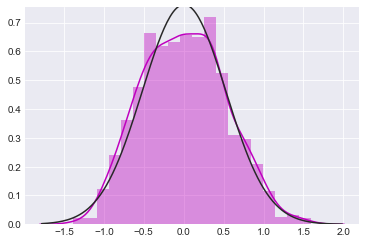

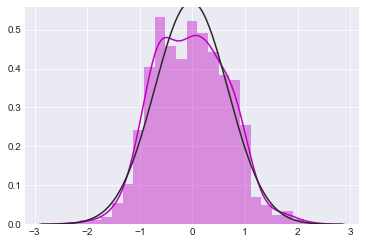

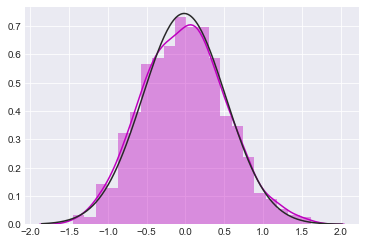

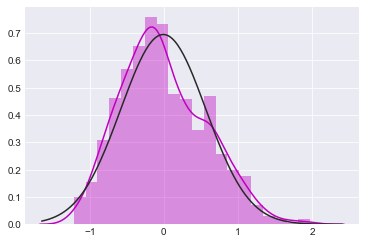

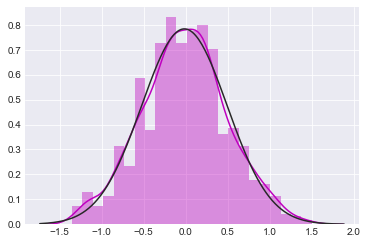

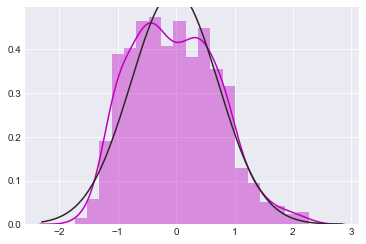

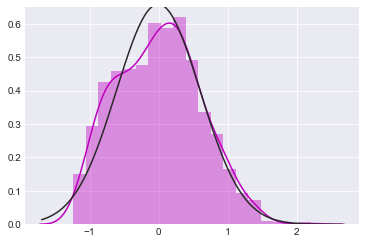

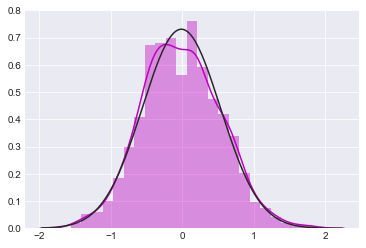

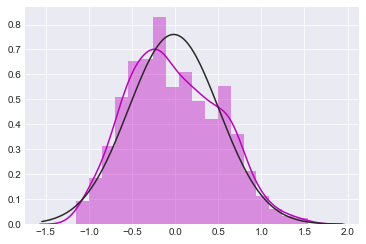

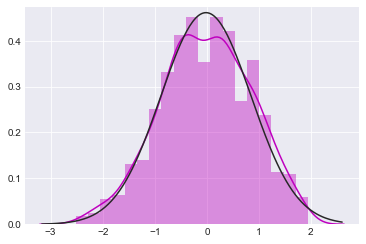

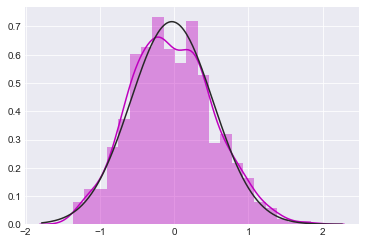

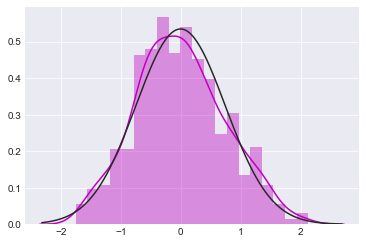

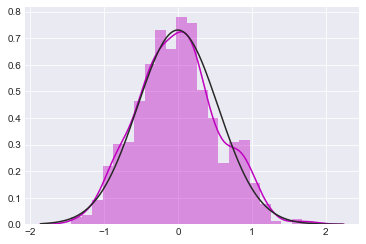

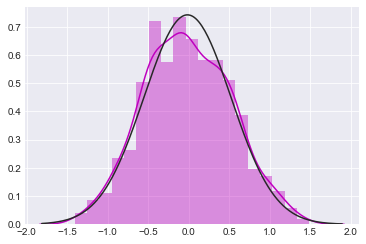

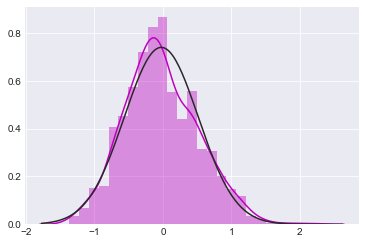

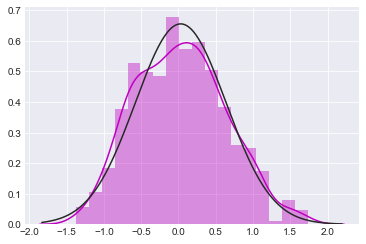

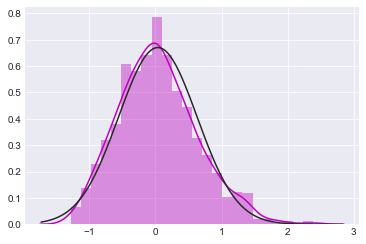

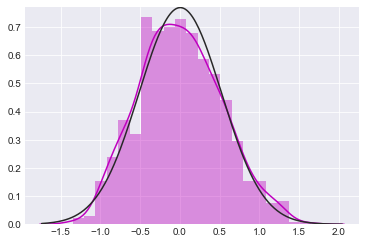

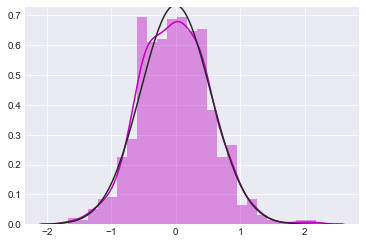

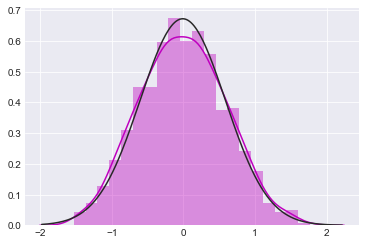

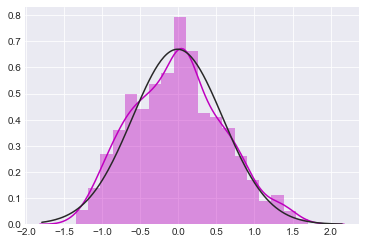

In [25]:
import matplotlib.pyplot as plt
for neuron in bootstrapped.columns:
    plt.figure()
    confidence_plot(bootstrapped, real_d_df, neuron);

In [18]:
# Running, No-Running, Non-selective